# Install library

In [1]:
import os
import random

import numpy as np
import pandas as pd
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from imblearn.over_sampling import SMOTE # smote

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
def set_randvalue(value):
    # Set a seed value
    seed_value= value 
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)
    # 2. Set `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)
    # 3. Set `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)
    # 4. Set `tensorflow` pseudo-random generator at a fixed value
    tf.random.set_seed(seed_value)

set_randvalue(42)

## Dataset preprocessing and EDA

In [19]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data() # load data
x_train,x_test = x_train.astype('float32')/255.0,x_test.astype('float32')/255.0 # normalization

In [4]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [5]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

#### Limit three class preprocessing

In [6]:
# No method on keras to get cifar10 category label name by categoly label?
cifar10_labels = np.array([
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'])

bird_num = np.where(cifar10_labels=='bird')
deer_num = np.where(cifar10_labels=='deer')
truck_num = np.where(cifar10_labels=='truck')

limit_num = 2500

# get limit label indexes
bird_indexes = [i for i, label in enumerate(y_train) if label == bird_num]
deer_indexes = [i for i, label in enumerate(y_train) if label == deer_num] 
truck_indexes = [i for i, label in enumerate(y_train) if label == truck_num] 
other_indexes = [i for i, label in enumerate(y_train) if label not in [bird_num, deer_num, truck_num]]

# limit
bird_indexes = bird_indexes[:limit_num]
deer_indexes = deer_indexes[:limit_num]
truck_indexes = truck_indexes[:limit_num]
print(f'Bird label num is {len(bird_indexes)}') # 2500
print(f'Deer label num is {len(deer_indexes)}') # 2500
print(f'Truck label num is {len(truck_indexes)}') # 2500
print(f'Other label num is {len(other_indexes)}') # 35000; 5000*7

# merge and sort
merge_indexes = np.concatenate([other_indexes, bird_indexes, deer_indexes, truck_indexes], 0)
merge_indexes.sort()
print(f'Train label num is {len(merge_indexes)}') # 42500

# create three labels removed train data
x_train_removed =  np.zeros((len(merge_indexes), 32, 32, 3))
y_train_removed =  np.zeros(len(merge_indexes))

for i, train_index in enumerate(merge_indexes):
    x_train_removed[i] = x_train[train_index]
    y_train_removed[i] = y_train[train_index]
    
print(x_train_removed.shape)
print(y_train_removed.shape)

Bird label num is 2500
Deer label num is 2500
Truck label num is 2500
Other label num is 35000
Train label num is 42500
(42500, 32, 32, 3)
(42500,)


In [7]:
print(x_train_removed.shape)
print(y_train_removed.shape)
del x_train
del y_train

(42500, 32, 32, 3)
(42500,)


In [8]:
df = pd.DataFrame(y_train_removed.flatten())
print(df.value_counts())
del df

8.0    5000
7.0    5000
6.0    5000
5.0    5000
3.0    5000
1.0    5000
0.0    5000
9.0    2500
4.0    2500
2.0    2500
dtype: int64


(array([5000., 5000., 2500., 5000., 2500., 5000., 5000., 5000., 5000.,
        2500.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

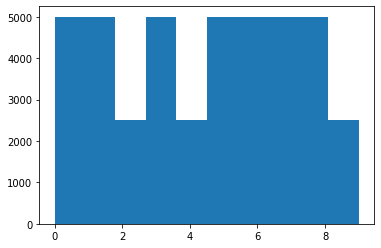

In [9]:
import matplotlib.pyplot as plt

# plot data labels
plt.hist(y_train_removed.flatten())

In [10]:
# train test split
# stratify y label
x_train_removed, x_valid_removed, y_train_removed, y_valid_removed = train_test_split(x_train_removed, y_train_removed, 
                                                                      test_size=0.3, random_state=42, stratify=y_train_removed)

In [11]:
print(x_train_removed.shape)
print(y_train_removed.shape)
print(x_valid_removed.shape)
print(y_valid_removed.shape)

(29750, 32, 32, 3)
(29750,)
(12750, 32, 32, 3)
(12750,)


In [12]:
df = pd.DataFrame(y_train_removed.flatten())
print(df.value_counts())
del df

8.0    3500
7.0    3500
6.0    3500
5.0    3500
3.0    3500
1.0    3500
0.0    3500
9.0    1750
4.0    1750
2.0    1750
dtype: int64


In [13]:
df = pd.DataFrame(y_valid_removed.flatten())
print(df.value_counts())
del df

8.0    1500
7.0    1500
6.0    1500
5.0    1500
3.0    1500
1.0    1500
0.0    1500
9.0     750
4.0     750
2.0     750
dtype: int64


#### SMOTE preprocessing

In [28]:
sm = SMOTE(random_state=42)
x_train_smote = x_train_removed.reshape(x_train_removed.shape[0],x_train_removed.shape[1]*x_train_removed.shape[2]*x_train_removed.shape[3])
y_train_smote = y_train_removed.reshape(y_train_removed.shape[0])
x_train_smote, y_train_smote = SMOTE().fit_resample(x_train_smote, y_train_smote)

In [29]:
x_train_smote = x_train_smote.reshape((x_train_smote.shape[0], x_train_removed.shape[1], x_train_removed.shape[2], x_train_removed.shape[3]))

In [30]:
print("Before smote X shape is ", x_train_removed.shape)
print("After smote X shape is ", x_train_smote.shape)

Before smote X shape is  (29750, 32, 32, 3)
After smote X shape is  (35000, 32, 32, 3)


In [32]:
df = pd.DataFrame(y_train_smote.flatten())
print(df.value_counts())
del df

9.0    3500
8.0    3500
7.0    3500
6.0    3500
5.0    3500
4.0    3500
3.0    3500
2.0    3500
1.0    3500
0.0    3500
dtype: int64


## AutoEncoder

#### Load AE models weight

In [33]:
# Batch Norm Model
def create_AE01_model(k_size):
    input_img = Input(shape=(32, 32, 3))  # 0
    conv1 = Conv2D(64, (k_size, k_size), padding='same', name="Dense_AE01_1")(input_img) # 1
    conv1 = BatchNormalization(name="BN_AE01_1")(conv1) # 2
    conv1 = Activation('relu', name="Relu_AE01_1")(conv1) # 3
        
    decoded = Conv2D(3, (k_size, k_size), padding='same', name="Dense_AE01_2")(conv1) # 4
    decoded = BatchNormalization(name="BN_AE01_2")(decoded) # 5
    decoded = Activation('relu', name="Relu_AE01_2")(decoded) # 6
    return Model(input_img, decoded)

class AE01():
    def __init__(self, ksize, optimizer):
        self.optimizer = optimizer
        
        self.autoencoder = create_AE01_model(ksize)
        self.encoder = None

    def compile(self, optimizer='adam', loss='binary_crossentropy'):
        self.autoencoder.compile(optimizer=self.optimizer, loss=loss)

    def train(self, x_train=None, x_test=None, epochs=1, batch_size=32, shuffle=True):
        es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
        ae_model_path = '../models/AE/AE01_AE_Best.hdf5'
        cp_cb = ModelCheckpoint(filepath = ae_model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
       
        history = self.autoencoder.fit(x_train, x_train,
                             epochs=epochs,
                             batch_size=batch_size,
                             shuffle=shuffle,
                             callbacks=[es_cb, cp_cb],
                             validation_data=(x_test, x_test))
        
        self.autoencoder.load_weights(ae_model_path)
        
        self.encoder = Model(self.autoencoder.input, self.autoencoder.get_layer('Relu_AE01_1').output)
        encode_model_path = '../models/AE/AE01_Encoder_Best.hdf5'
        self.encoder.save(encode_model_path)
        return history
    
    def load_weights(self, ae_model_path, encode_model_path):
        self.autoencoder.load_weights(ae_model_path)
        self.encoder = Model(self.autoencoder.input, self.autoencoder.get_layer('Relu_AE01_1').output)
        self.encoder.load_weights(encode_model_path)

In [34]:
ae_ksize = 3
ae_optimizer = 'rmsprop'
stack01 = AE01(ae_ksize, ae_optimizer)
stack01.load_weights('../models/AE/AE01_AE_Best.hdf5', '../models/AE/AE01_Encoder_Best.hdf5')
stack01.encoder.trainable = False
stack01.encoder.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
Dense_AE01_1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
BN_AE01_1 (BatchNormalizatio (None, 32, 32, 64)        256       
_________________________________________________________________
Relu_AE01_1 (Activation)     (None, 32, 32, 64)        0         
Total params: 2,048
Trainable params: 0
Non-trainable params: 2,048
_________________________________________________________________


## Train

#### Create Model AE to CNN

In [35]:
def create_StackedAE01_CNN01_model(encoder):
    input_img = encoder.input
    output = encoder.layers[-1].output # 32,32,64
    x = Conv2D(64,(3,3),padding = "same",activation= "relu")(output)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x) # 16,16,64
    
    x = Conv2D(128,(3,3),padding = "same",activation= "relu")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128,(3,3),padding = "same",activation= "relu")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x) # 8,8,128
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    y = Dense(10,activation = "softmax")(x)

    return Model(input_img, y)

model01 = create_StackedAE01_CNN01_model(stack01.encoder)
model01.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
Dense_AE01_1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
BN_AE01_1 (BatchNormalizatio (None, 32, 32, 64)        256       
_________________________________________________________________
Relu_AE01_1 (Activation)     (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)       

#### Train without data augumentation 

In [37]:
adam = Adam() # defalut
model01.compile(loss = "categorical_crossentropy", optimizer = adam, metrics = ["accuracy"])

# one hot encoding
nb_classes = 10
# y_train_removed_onehot = to_categorical(y_train_removed, nb_classes)
y_train_smote_onehot = to_categorical(y_train_smote, nb_classes)
y_valid_removed_onehot = to_categorical(y_valid_removed, nb_classes)
y_test_onehot = to_categorical(y_test, nb_classes)

In [38]:
%%time

# train
saveDir = "../models/CNN/"

es_cb = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
chkpt = saveDir + 'Model_021_Best.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, \
       monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

model01_history = model01.fit(x_train_smote, y_train_smote_onehot,
                      batch_size=32,
                      epochs=400,
                      verbose=1,
                      validation_data=(x_valid_removed, y_valid_removed_onehot),
                      callbacks=[es_cb, cp_cb],
                      shuffle=True)

Epoch 1/400
1094/1094 [==============================] - ETA: 0s - loss: 1.3254 - accuracy: 0.5256
Epoch 00001: val_loss improved from inf to 1.24149, saving model to ../models/CNN\Model_021_Best.hdf5
1094/1094 [==============================] - 6s 6ms/step - loss: 1.3254 - accuracy: 0.5256 - val_loss: 1.2415 - val_accuracy: 0.5708
Epoch 2/400
1092/1094 [============================>.] - ETA: 0s - loss: 0.9303 - accuracy: 0.6703
Epoch 00002: val_loss improved from 1.24149 to 0.89937, saving model to ../models/CNN\Model_021_Best.hdf5
1094/1094 [==============================] - 6s 5ms/step - loss: 0.9302 - accuracy: 0.6703 - val_loss: 0.8994 - val_accuracy: 0.6813
Epoch 3/400
1093/1094 [============================>.] - ETA: 0s - loss: 0.7455 - accuracy: 0.7372
Epoch 00003: val_loss did not improve from 0.89937
1094/1094 [==============================] - 6s 5ms/step - loss: 0.7455 - accuracy: 0.7371 - val_loss: 1.0259 - val_accuracy: 0.6612
Epoch 4/400
1087/1094 [======================

Text(0.5, 0, 'epoch')

<Figure size 432x288 with 0 Axes>

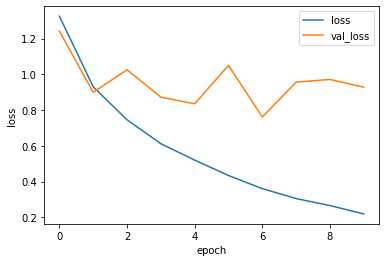

<Figure size 432x288 with 0 Axes>

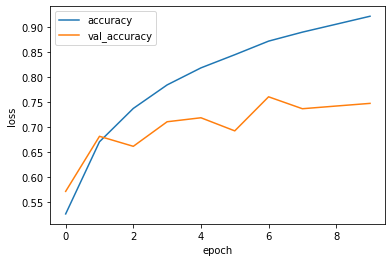

In [39]:
# plot training
mdoel01_hist_df = pd.DataFrame(model01_history.history)

plt.figure()
mdoel01_hist_df[['loss', 'val_loss']].plot()
plt.ylabel('loss')
plt.xlabel('epoch')

plt.figure()
mdoel01_hist_df[['accuracy', 'val_accuracy']].plot()
plt.ylabel('loss')
plt.xlabel('epoch')

In [40]:
model01.load_weights('../models/CNN/Model_021_Best.hdf5')
model01.evaluate(x_test, y_test_onehot)

313/313 [==============================] - 1s 2ms/step - loss: 0.8071 - accuracy: 0.7480


[0.8070758581161499, 0.7480000257492065]

In [41]:
y_pred = model01.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.74      0.78      1000
           1       0.87      0.86      0.86      1000
           2       0.71      0.60      0.65      1000
           3       0.53      0.68      0.60      1000
           4       0.81      0.58      0.68      1000
           5       0.65      0.73      0.69      1000
           6       0.74      0.82      0.77      1000
           7       0.75      0.81      0.78      1000
           8       0.88      0.85      0.86      1000
           9       0.84      0.80      0.82      1000

    accuracy                           0.75     10000
   macro avg       0.76      0.75      0.75     10000
weighted avg       0.76      0.75      0.75     10000



#### Train with data augumentation 1

In [42]:
encoder = stack01.encoder
encoder.trainable = False
model02 = create_StackedAE01_CNN01_model(encoder) # transfer learning

adam = Adam() # defalut
model02.compile(loss = "categorical_crossentropy", optimizer = adam, metrics = ["accuracy"])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/400
1093/1093 [==============================] - ETA: 0s - loss: 1.3932 - accuracy: 0.4971
Epoch 00001: val_loss improved from inf to 1.22787, saving model to ../models/CNN\Model_022_Best.hdf5
1093/1093 [==============================] - 10s 9ms/step - loss: 1.3932 - accuracy: 0.4971 - val_loss: 1.2279 - val_accuracy: 0.5781
Epoch 2/400
1093/1093 [==============================] - ETA: 0s - loss: 1.0134 - accuracy: 0.6432
Epoch 00002: val_loss did not improve from 1.22787
1093/1093 [==============================] - 10s 9ms/step - loss: 1.0134 - accuracy: 0.6432 - val_loss: 1.2407 - val_accuracy: 0.5857
Epoch 3/400
1090/1093 [============================>.] - ETA: 0s - loss: 0.8427 - accuracy: 0.7009
Epoch 00003: val_loss improved from 1.22787 to 0.93534, saving model to ../models/CNN\Model_022_Best.hdf5
1093/1093 [==============================] - 13s 12ms/step - loss: 0.8425 - accuracy: 0.7008 - val_l

Text(0.5, 0, 'epoch')

<Figure size 432x288 with 0 Axes>

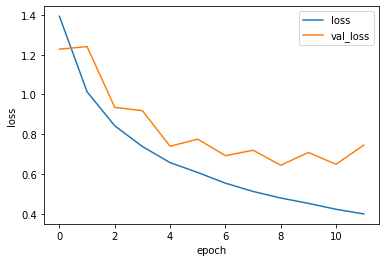

<Figure size 432x288 with 0 Axes>

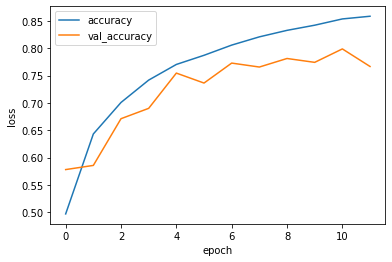

In [43]:
%%time

# one hot encoding
nb_classes = 10
# y_train_removed_onehot = to_categorical(y_train_removed, nb_classes)
y_train_smote_onehot = to_categorical(y_train_smote, nb_classes)
y_valid_removed_onehot = to_categorical(y_valid_removed, nb_classes)
y_test_onehot = to_categorical(y_test, nb_classes)

es_cb = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
chkpt = saveDir + 'Model_022_Best.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, \
       monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=10,
#     shear_range=0.2,
    horizontal_flip=True,
#     vertical_flip=True,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
    zoom_range=0.1
#     channel_shift_range=0.2
    )

batch_size = 32
train_datagenerator = train_datagen.flow(x_train_smote, y_train_smote_onehot, batch_size)
valid_datagenerator = ImageDataGenerator().flow(x_valid_removed, y_valid_removed_onehot, batch_size)

model02_history = model02.fit_generator(train_datagenerator,
                              steps_per_epoch=int(len(x_train_smote)//batch_size),
                              epochs=400,
                              validation_data=valid_datagenerator,
                              validation_steps=int(len(x_valid_removed)//batch_size),
                              verbose=1,
                              shuffle=True,
                              callbacks=[es_cb, cp_cb])

# plot training
mdoel02_hist_df = pd.DataFrame(model02_history.history)

plt.figure()
mdoel02_hist_df[['loss', 'val_loss']].plot()
plt.ylabel('loss')
plt.xlabel('epoch')

plt.figure()
mdoel02_hist_df[['accuracy', 'val_accuracy']].plot()
plt.ylabel('loss')
plt.xlabel('epoch')

In [44]:
model02.load_weights('../models/CNN/Model_022_Best.hdf5')
model02.evaluate(x_test, y_test_onehot)

313/313 [==============================] - 1s 3ms/step - loss: 0.7241 - accuracy: 0.7616


[0.724074125289917, 0.7616000175476074]

In [45]:
y_pred = model02.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.83      0.80      1000
           1       0.88      0.91      0.89      1000
           2       0.75      0.65      0.70      1000
           3       0.78      0.43      0.55      1000
           4       0.91      0.52      0.66      1000
           5       0.71      0.70      0.71      1000
           6       0.62      0.94      0.74      1000
           7       0.66      0.91      0.77      1000
           8       0.84      0.89      0.87      1000
           9       0.89      0.82      0.85      1000

    accuracy                           0.76     10000
   macro avg       0.78      0.76      0.75     10000
weighted avg       0.78      0.76      0.75     10000

